<center> <img src = https://raw.githubusercontent.com/AndreyRysistov/DatasetsForPandas/main/hh%20label.jpg alt="drawing" style="width:400px;">

# <center> Проект: Анализ вакансий из HeadHunter
   

In [245]:
import pandas as pd
import psycopg2
import os
import plotly.graph_objects as go
import requests
from bs4 import BeautifulSoup
# Скрыть предупреждения от pandas об использовании другого модуля подключения к SQL
import warnings
warnings.filterwarnings('ignore')

In [246]:
# вставьте сюда параметры подключения из юнита 1. Работа с базой данных из Python

# Подгрузка данных для подключения из файла .env
DBNAME = os.environ["DBNAME"]
USER = os.environ["USER"]
PASSWORD = os.environ["PASSWORD"]
HOST = os.environ["HOST"]
PORT = os.environ["PORT"]

In [247]:
connection = psycopg2.connect(
    dbname=DBNAME,
    user=USER,
    host=HOST,
    password=PASSWORD,
    port=PORT
)

# Юнит 3. Предварительный анализ данных

1. Напишите запрос, который посчитает количество вакансий в нашей базе (вакансии находятся в таблице vacancies). 

In [248]:
# текст запроса
query_3_1 = f'''
             SELECT COUNT(v.id)
             FROM vacancies AS v
             '''

In [249]:
# результат запроса
df_3 = pd.read_sql_query(query_3_1, connection)
print(f"Количество вакансий в базе данных: {df_3['count'][0]}")

Количество вакансий в базе данных: 49197


2. Напишите запрос, который посчитает количество работодателей (таблица employers). 

In [250]:
# текст запроса
query_3_2 = f'''
             SELECT COUNT(e.id)
             FROM employers AS e
             '''

In [251]:
# результат запроса
df_3 = pd.read_sql_query(query_3_2, connection)
print(f"Количество работодателей в базе данных: {df_3['count'][0]}")

Количество работодателей в базе данных: 23501


3. Посчитате с помощью запроса количество регионов (таблица areas).

In [252]:
# текст запроса
query_3_3 = f'''
             SELECT COUNT(a.id)
             FROM areas AS a
             '''

In [253]:
# результат запроса
df_3 = pd.read_sql_query(query_3_3, connection)
print(f"Количество регионов в базе данных: {df_3['count'][0]}")

Количество регионов в базе данных: 1362


4. Посчитате с помощью запроса количество сфер деятельности в базе (таблица industries).

In [254]:
# текст запроса
query_3_4 = f'''
             SELECT COUNT(i.id)
             FROM industries AS i
             '''

In [255]:
# результат запроса
df_3 = pd.read_sql_query(query_3_4, connection)
print(f"Количество сфер деятельности в базе данных: {df_3['count'][0]}")

Количество сфер деятельности в базе данных: 294


***

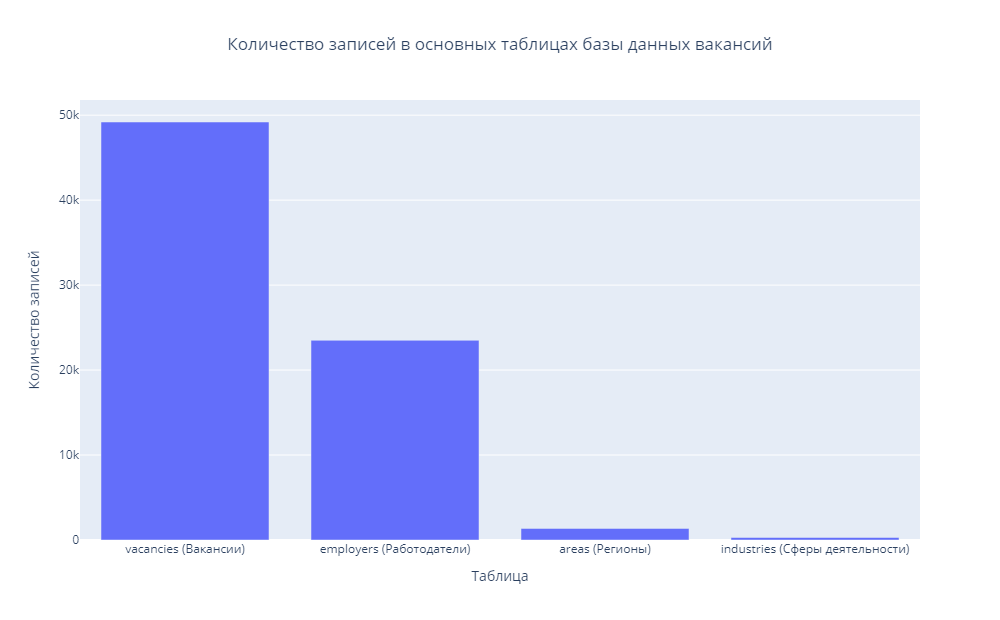

In [256]:
# выводы по предварительному анализу данных
# Общий запрос количества записей в основных таблицах
query_3 = f'''
           SELECT ({query_3_1}) AS "vacancies (Вакансии)",
                  ({query_3_2}) AS "employers (Работодатели)",
                  ({query_3_3}) AS "areas (Регионы)",
                  ({query_3_4}) AS "industries (Сферы деятельности)"
           '''
df_3 = pd.read_sql_query(query_3, connection)

# Построение баров
figure_db = go.Figure(data=go.Bar(x=df_3.columns,
                                  y=df_3.iloc[0]))
# Размер полотна
figure_db.update_layout(autosize = False, width = 1000, height = 620)
# Заголовк и подписи осей
figure_db.update_layout(title='Количество записей в основных таблицах базы данных вакансий',
                        title_x=0.5, # Выравнивание заголовка посередине
                        xaxis_title='Таблица', # Подпись Х
                        yaxis_title='Количество записей') # Подпись Y
figure_db.show("png")

Предварительный анализ базы данных показывает, что в ней содержится информация:
- об открытых вакансиях (49197 записи);
- о работодателях (23501 записей);
- о сферах деятельности работодателей (294 записи);
- о регионах (1362 записи).

# Юнит 4. Детальный анализ вакансий

1. Напишите запрос, который позволит узнать, сколько (cnt) вакансий в каждом регионе (area).
Отсортируйте по количеству вакансий в порядке убывания.

In [257]:
# текст запроса
query_4_1 = f'''
             SELECT 
                 a.name AS area,
                 COUNT(v.id) AS cnt
             FROM vacancies AS v
             LEFT JOIN areas AS a
                 ON v.area_id = a.id
             GROUP BY a.name
             ORDER BY cnt DESC
             '''

In [258]:
# результат запроса
df_4_1 = pd.read_sql_query(query_4_1, connection)
print('Количество вакансий по регионам (TOP-5):')
print(df_4_1.head(5))

Количество вакансий по регионам (TOP-5):
              area   cnt
0           Москва  5333
1  Санкт-Петербург  2851
2            Минск  2112
3      Новосибирск  2006
4           Алматы  1892


2. Напишите запрос, чтобы определить у какого количества вакансий заполнено хотя бы одно из двух полей с зарплатой.

In [259]:
# текст запроса
query_4_2 = f'''
             SELECT COUNT(v.id)
             FROM vacancies AS v
             WHERE v.salary_from IS NOT NULL
                OR v.salary_to IS NOT NULL
             '''

In [260]:
# результат запроса
df_4 = pd.read_sql_query(query_4_2, connection)
print(f"Количество вакансий с указанной зарплатой: {df_4['count'][0]}")

Количество вакансий с указанной зарплатой: 24073


3. Найдите средние значения для нижней и верхней границы зарплатной вилки. Округлите значения до целого.

In [261]:
# текст запроса
query_4_3 = f'''
             SELECT 
                 ROUND(AVG(v.salary_from)) AS "Средний нижний порог ЗП",
                 ROUND(AVG(v.salary_to)) AS "Средний верхний порог ЗП"
             FROM vacancies AS v
             '''

In [262]:
# результат запроса
df_4 = pd.read_sql_query(query_4_3, connection)
print('Средние значения зарплатной вилки:')
print(df_4)

Средние значения зарплатной вилки:
   Средний нижний порог ЗП  Средний верхний порог ЗП
0                  71065.0                  110537.0


4. Напишите запрос, который выведет количество вакансий для каждого сочетания типа рабочего графика (schedule) и типа трудоустройства (employment), используемого в вакансиях. Результат отсортируйте по убыванию количества.


In [263]:
# текст запроса
query_4_4 = f'''
             SELECT 
                 v.schedule AS "Тип рабочего графика",
                 v.employment AS "Тип трудоустройства",
                 COUNT(v.id) AS "Количество вакансий"
             FROM vacancies AS v
             GROUP BY 
                 v.schedule,
                 v.employment
             ORDER BY COUNT(v.id) DESC
             '''

In [264]:
# результат запроса
df_4_4 = pd.read_sql_query(query_4_4, connection)
print('Количество вакансий по типам рабочего графика и трудоустройства:')
print(df_4_4)

Количество вакансий по типам рабочего графика и трудоустройства:
   Тип рабочего графика  Тип трудоустройства  Количество вакансий
0           Полный день     Полная занятость                35367
1      Удаленная работа     Полная занятость                 7802
2         Гибкий график     Полная занятость                 1593
3      Удаленная работа  Частичная занятость                 1312
4        Сменный график     Полная занятость                  940
5           Полный день           Стажировка                  569
6        Вахтовый метод     Полная занятость                  367
7           Полный день  Частичная занятость                  347
8         Гибкий график  Частичная занятость                  312
9           Полный день     Проектная работа                  141
10     Удаленная работа     Проектная работа                  133
11        Гибкий график           Стажировка                  116
12       Сменный график  Частичная занятость                  101
13     Удал

5. Напишите запрос, выводящий значения поля Требуемый опыт работы (experience) в порядке возрастания количества вакансий, в которых указан данный вариант опыта. 

In [265]:
# текст запроса
query_4_5 = f'''
             SELECT 
                 v.experience AS "Опыт работы",
                 COUNT(v.id) AS "Количество вакансий"
             FROM vacancies AS v
             GROUP BY v.experience
             ORDER BY COUNT(v.id)
             '''

In [266]:
# результат запроса
df_4_5 = pd.read_sql_query(query_4_5, connection)
print('Количество вакансий по категориям требуемого опыта работы:')
print(df_4_5)

Количество вакансий по категориям требуемого опыта работы:
          Опыт работы  Количество вакансий
0         Более 6 лет                 1337
1           Нет опыта                 7197
2       От 3 до 6 лет                14511
3  От 1 года до 3 лет                26152


***

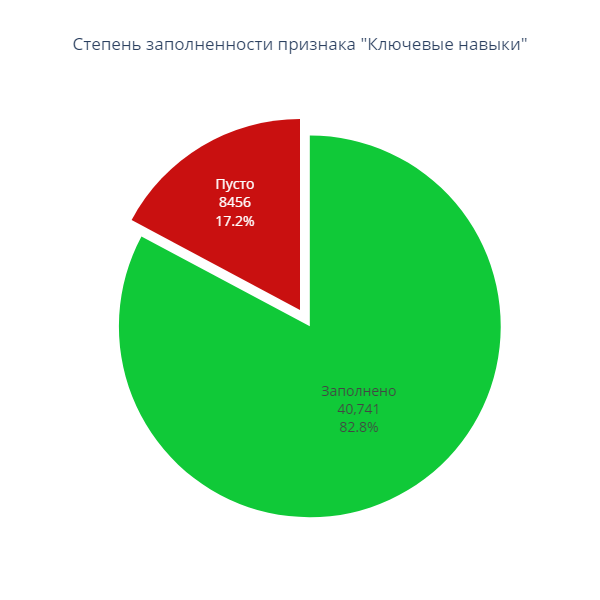

Количество уникальных значений признака 'Ключевые навыки':31218


In [267]:
# Степень заполненности признака Ключевые навыки
query_key_skills = f'''
                    SELECT 
                        COUNT(v.key_skills) AS "Заполнено",
                        COUNT(v.id) - COUNT(v.key_skills) AS "Пусто"
                    FROM vacancies AS v
                    '''
df_key_skills = pd.read_sql_query(query_key_skills, connection)

# Построение круговой диаграммы
figure_key_skills = go.Figure(data=[go.Pie(labels=df_key_skills.columns,
                                           values=df_key_skills.iloc[0])])
# Стиль отображения
figure_key_skills.update_traces(textinfo='label+percent+value', # Содержимое подписи
                                textfont_size=14, # Размер шрифта подписи
                                pull=[0.1, 0], # Сдвиг сектора
                                marker=dict(colors=["#10c938", "#c91010"]), # Цвета секторов
                                showlegend=False) # Скрыть легенду
# Размер полотна
figure_key_skills.update_layout(autosize = False, width = 600, height = 600)
# Заголовок диаграммы
figure_key_skills.update_layout(title='Степень заполненности признака "Ключевые навыки"',
                                title_x=0.5) # Расположение посередине
figure_key_skills.show("png")

# Количество уникальных значений Ключевых навыков
query_key_skills = f'''
                    SELECT 
                        COUNT(DISTINCT v.key_skills)
                    FROM vacancies AS v
                    '''
df_key_skills = pd.read_sql_query(query_key_skills, connection)
print(f"Количество уникальных значений признака 'Ключевые навыки':{df_key_skills['count'][0]}")

Рассматривая степень заполненности признака "Ключевые навыки" стоит отметить, что пустые значения составляют порядка 17%. При этом на этапе очистки данных от пропусков следует обратить внимание, что для отдельных вакансий ключевые навыки могут быть не так важны изначально, например, если вакансия не требует опыта работы. В этом случае требование к наличию ключевых навыков отсутствует и поле должно быть заполнено соответствующей категорией, например, "Не требуются". Для остальных случаев можно данный признак заполнить модами подгрупп, выделяемых на основании признаков "Название вакансии" и "Требования к опыту".  
Количество уникальных значений признака показывает на необходимость преобразования данных, а именно определения общего списка возможных ключевых навыков, при необходимости объединения семантически схожих и выделения каждого навыка получившегося списка как отдельного признака для каждой вакансии.

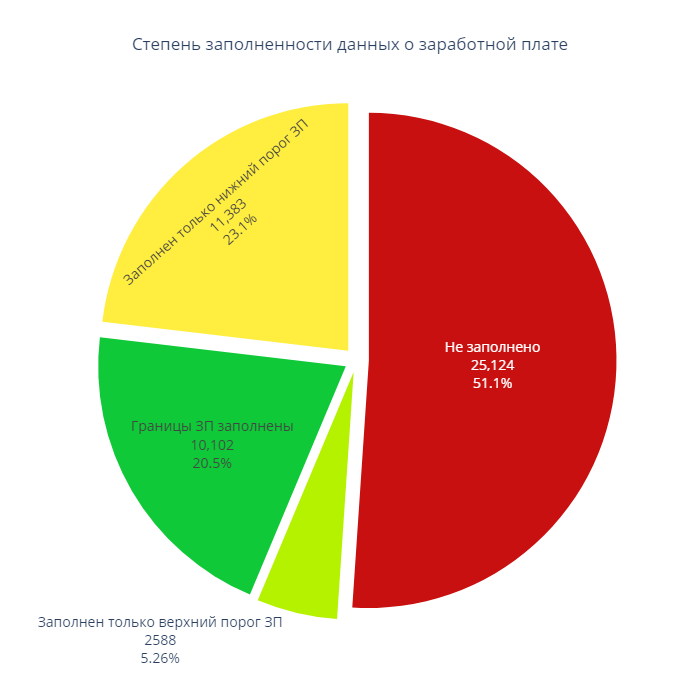

In [268]:
# Степень заполненности признаков Нижняя граница зарплатной вилки
# и Верхняя граница зарплатной вилки 
query_salary = f'''
                SELECT 
                -- Количество вакансий с заполненными гранницами зарплатной вилки
                    (SELECT COUNT(v.id) 
                     FROM vacancies AS v
                     WHERE v.salary_from IS NOT NULL AND v.salary_to IS NOT NULL)
                        AS "Границы ЗП заполнены",
                -- Количество вакансий с заполненной только верхней гранницей зарплатной вилки
                    (SELECT COUNT(v.id) 
                     FROM vacancies AS v
                     WHERE v.salary_from IS NULL AND v.salary_to IS NOT NULL)
                        AS "Заполнен только верхний порог ЗП",
                -- Количество вакансий с заполненной только нижней гранницей зарплатной вилки
                    (SELECT COUNT(v.id) 
                     FROM vacancies AS v
                     WHERE v.salary_from IS NOT NULL AND v.salary_to IS NULL)
                        AS "Заполнен только нижний порог ЗП",
                -- Количество вакансий с незаполненными гранницами зарплатной вилки
                    (SELECT COUNT(v.id) 
                     FROM vacancies AS v
                     WHERE v.salary_from IS NULL AND v.salary_to IS NULL)
                        AS "Не заполнено"
                '''
df_salary = pd.read_sql_query(query_salary, connection)

# Построение круговой диаграммы
figure_salary = go.Figure(data=[go.Pie(labels=df_salary.columns,
                                       values=df_salary.iloc[0])])
# Стиль отображения
figure_salary.update_traces(textinfo='label+percent+value', # Содержимое подписи
                            textfont_size=14, # Размер шрифта подписи
                            pull=[0.05, 0.05, 0.05, 0.05], # Сдвиг сектора
                            marker=dict(colors=["#10c938", "#B4F200", "#FFEE40", "#c91010"]), # Цвета секторов
                            showlegend=False) # Скрыть легенду
# Размер полотна
figure_salary.update_layout(autosize = False, width = 700, height = 700)
# Заголовок диаграммы
figure_salary.update_layout(title='Степень заполненности данных о заработной плате',
                                title_x=0.5) # Расположение посередине
figure_salary.show("png")

Степень заполненности данных о предполагаемой заработной плате (далее ЗП) (признаки "Нижняя граница заработной вилки" и "Верхняя граница заработной вилки") крайне низкая, полностью отсутствуют значения в 51% вакансий, полные данные указаны только в 20%, в остальных - частично.  
На этапе очистки данных от пропусков вероятнее всего введение категории данных по признакам, описывающим ЗП, "Не указана". Частично пропуски рекомендуется заполнить средними значениями подгрупп вакансий, выделяемых по следующим критериям (указаны в порядке понижения важности):
- Название вакансии
- Регион
- Требования к опыту
- Тип рабочего графика
- Тип трудоустройства  

При этом предварительно необходимо провести анализ общего уровня ЗП по регионам и вывести относительный коэффициент ЗП для каждого из них. Данный коэффициент поможет оценить примерный уровень ЗП в случае отсутствия подобных вакансий в указанном регионе и при наличии в других.

Основной причиной низкой степени заполненности данных о предполагаемой ЗП является подход работодателей в определении размера ЗП по результатам собеседований с определением в качестве отправной точки зарплатных ожиданий соискателей.

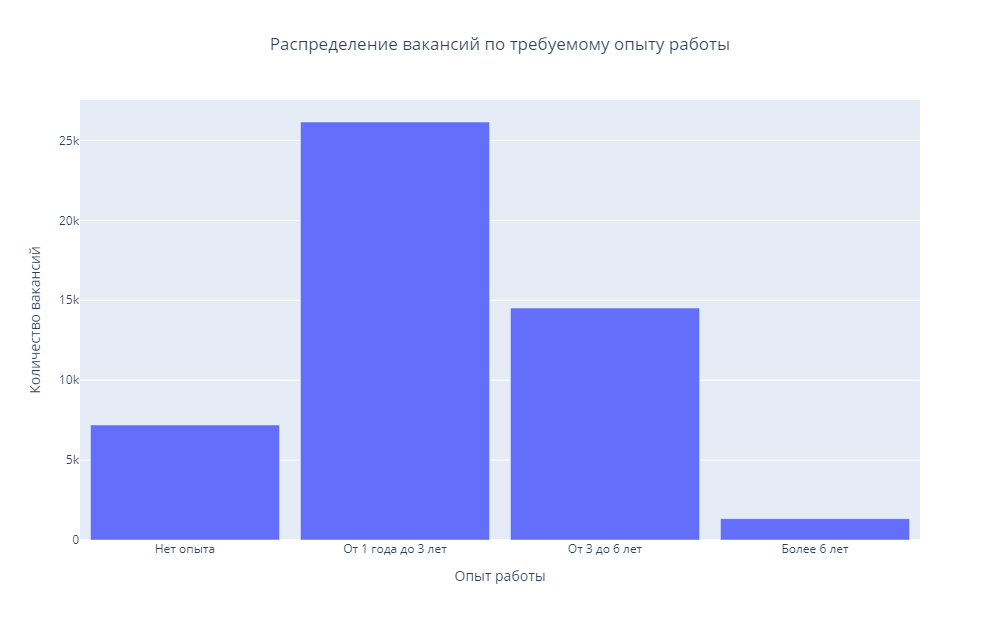

In [269]:
# Распределение категорий признака Требования к опыту
figure_experience = go.Figure(data=go.Bar(x=df_4_5['Опыт работы'],
                                          y=df_4_5['Количество вакансий']))
figure_experience.update_layout(autosize = False, width = 1000, height = 620, # Размер полотна
                                legend=dict(y=0.75), # Положение легенды
                                bargap=0.1) # Расстояние между столбцами
# Порядок вывода категорий
figure_experience.update_xaxes(categoryorder='array',
                               categoryarray=["Нет опыта", "От 1 года до 3 лет", "От 3 до 6 лет", "Более 6 лет"]) 
# Заголовк и подписи осей
figure_experience.update_layout(title='Распределение вакансий по требуемому опыту работы',
                                title_x=0.5, # Выравнивание заголовка посередине
                                xaxis_title='Опыт работы', # Подпись Х
                                yaxis_title='Количество вакансий') # Подпись Y
figure_experience.show("png")

Распределение количества открытых вакансий в разрезе "Опыта работы" представлено на диаграмме. Справедливо предположить, что данное распределение определено необходимостью заполнения вакансий начального уровня и желанием работодателей даже на подобные должности подбирать работников хотя бы с минимальным опытом работы (1-3 года). Далее по мере приобретения опыта работы подавляющая часть работников продолжает свой карьерный рост в пределах одной компании, что не требует поиска работника на сторонних ресурсах. Таким образом, количество открытых вакансий снижается по мере увеличения требуемого опыта работы. В категорию без опыта работы вероятнее всего попадают запросы для проведения стажировок и на низкоквалифицированные кадры для проведения работ, не требующих ключевых навыков.

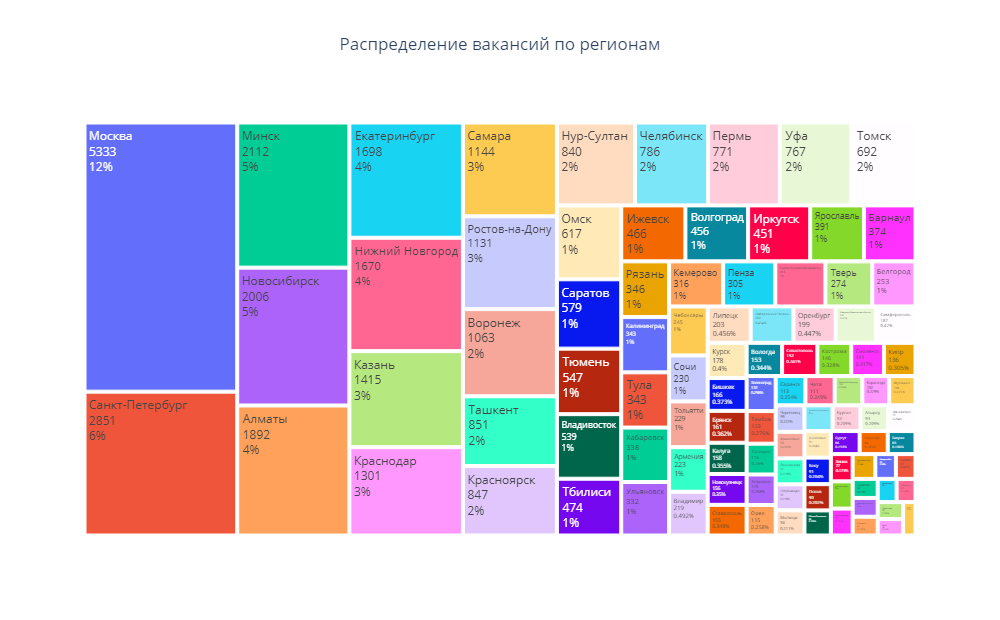

Вакансии открыты в 769 регионах.


In [270]:
# Распределение вакансий по Регионам
query_vacancies_areas = f'''
                         SELECT 
                             a.name AS "Регион",
                             COUNT(v.id) AS "Количество вакансий"
                         FROM vacancies AS v
                         LEFT JOIN areas AS a
                            ON v.area_id = a.id
                         GROUP BY a.name
                         ORDER BY COUNT(v.id) DESC
                         '''
df_vacancies_areas = pd.read_sql_query(query_vacancies_areas, connection)

# Построение иерархической диаграммы регионов с открытыми вакансиями,
# на графике отображаем первые 100 регионов
figure_vacancies_areas = go.Figure(data=go.Treemap(labels=df_vacancies_areas['Регион'].head(100),
                                                   parents=list([""]*df_vacancies_areas.shape[0]),
                                                   values=df_vacancies_areas['Количество вакансий'],
                                                   textinfo = "label+value+percent root"))
figure_vacancies_areas.update_layout(autosize = False, width = 1000, height = 620, # Размер полотна
                                     title='Распределение вакансий по регионам', # Заголовок
                                     title_x=0.5) # Выравнивание заголовка посередине
figure_vacancies_areas.show("png")

print(f'Вакансии открыты в {df_vacancies_areas.shape[0]} регионах.')

Открытые вакансии представлены в 769 регионах. При этом 14 регионов включают в себя половину всех предложений. Top-5 из них:
- Москва (11%);
- Санкт-Петербург (6%);
- Минск (4%);
- Новосибирск (4%);
- Алматы (4%).

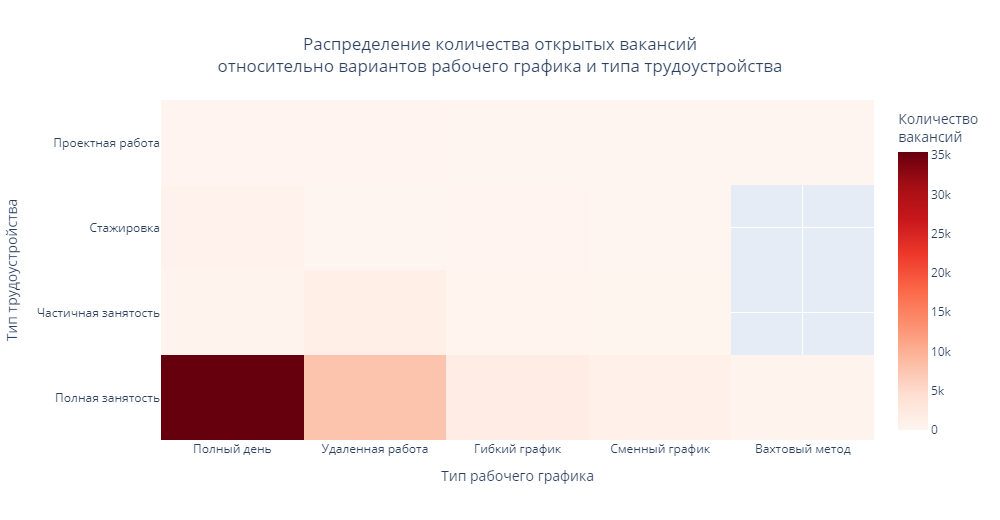

In [271]:
# Тепловая карта Тип рабочего графика - Тип трудоустройства
figure_schedule_employment = go.Figure(data=go.Heatmap(x=df_4_4['Тип рабочего графика'],
                                                       y=df_4_4['Тип трудоустройства'],
                                                       z=df_4_4['Количество вакансий'],
                                                       colorscale='Reds',
                                                       colorbar_title = 'Количество<br>вакансий'))
# Размер полотна
figure_schedule_employment.update_layout(autosize = False, width = 1000, height = 520)
# Заголовк и подписи осей
figure_schedule_employment.update_layout(title='Распределение количества открытых вакансий\
<br>относительно вариантов рабочего графика и типа трудоустройства',
                                             title_x=0.5, # Выравнивание заголовка посередине
                                             yaxis_title='Тип трудоустройства', # Подпись Y
                                             xaxis_title='Тип рабочего графика') # Подпись Х
figure_schedule_employment.show("png")

Тепловая карта "Распределение количества открытых вакансий относительно вариантов рабочего графика и типа трудоустройства" позволяет выделить в качестве группы с наиболее большим количеством вакансий сочетания категори "Полная занятость" с типами рабочего графика "Полный день" и "Удаленная работа". Наиболее вероятно данное обстоятельство определяется заинтересованностью работодателей в полном погружении основных должностных лиц в свои обязанности. Также частичная занятость предполагает наличие у работника другой основной работы (с частичной или полной занятостью), что повышает текучесть кадров по подобным вакансиям.

In [272]:
# Распределение вакансий по наименованиям
query_vacancies = f'''
                   SELECT 
                       v.name AS "Название вакансии",
                       COUNT(v.id) AS "Количество"
                   FROM vacancies AS v
                   GROUP BY v.name
                   ORDER BY COUNT(v.id) DESC
                   '''
df_vacancies = pd.read_sql_query(query_vacancies, connection)

print(f'Уникальных наименований вакансий: {df_vacancies.shape[0]}.')
print(df_vacancies.head(10))
print(f"Количество наименований вакансий, представленных только в одном экземпляре: {df_vacancies[df_vacancies['Количество'] == 1].shape[0]}")

Уникальных наименований вакансий: 21223.
                  Название вакансии  Количество
0           Системный администратор        1761
1                    Программист 1С        1153
2                   Бизнес-аналитик         488
3  Специалист технической поддержки         457
4                Системный аналитик         432
5                          Аналитик         404
6               Инженер-программист         389
7                    Программист 1C         360
8              Frontend-разработчик         242
9     Инженер технической поддержки         230
Количество наименований вакансий, представленных только в одном экземпляре: 16435


Обзор названий вакансий показывает, что порядка 77% из них не повторяются. Так как название является одним из ключевых признаков для подбора вакансий данное обстоятельство свидетельствует о необходимости наиболее детальной проработки и анализа, а также формирования гибкого подхода к фильтрации по данному признаку.

***

Таким образом, в ходе детального анализа вакансий выявлены следующие особенности:
- снижение количества открытых вакансий по мере увеличения требуемого опыта работы;
- наибольшее количество вакансий представлено в крупных регионах;
- преобладают вакансии с полной занятостью на полный день или удаленно.

Также следует отметить низкую степень заполненности данных о предполагаемой заработной плате, необходимость преобразования данных признака "Ключевые навыки" и необходимость детального анализа и формирования гибкого подхода к фильтрации по названию вакансий.

# Юнит 5. Анализ работодателей

1. Напишите запрос, который позволит узнать, какие работодатели находятся на первом и пятом месте по количеству вакансий.

In [273]:
# текст запроса
query_5_1 = f'''
             SELECT
             -- Работодатель, занимающий 1 место
                (SELECT e.name AS "Работодатель"
                FROM vacancies AS v
                LEFT JOIN employers AS e
                    ON v.employer_id = e.id
                GROUP BY e.name
                ORDER BY COUNT(v.id) DESC
                LIMIT 1) AS "1",
             -- Работодатель, занимающий 5 место
                (SELECT e.name AS "Работодатель"
                FROM vacancies AS v
                LEFT JOIN employers AS e
                    ON v.employer_id = e.id
                GROUP BY e.name
                ORDER BY COUNT(v.id) DESC
                OFFSET 4
                LIMIT 1) AS "5"
             '''

In [274]:
# результат запроса
df_5_1 = pd.read_sql_query(query_5_1, connection)
print(df_5_1)

        1              5
0  Яндекс  Газпром нефть


2. Напишите запрос, который для каждого региона выведет количество работодателей и вакансий в нём.
Среди регионов, в которых нет вакансий, найдите тот, в котором наибольшее количество работодателей.


In [275]:
# текст запроса
query_5_2 = f'''
             SELECT 
                a.name AS "Регион",
                COUNT(DISTINCT e.id) AS "Количество работодателей",
                COUNT(DISTINCT v.id) AS "Количество вакансий" 
             FROM areas as a
             LEFT JOIN vacancies AS v
                 ON a.id = v.area_id
             LEFT JOIN employers AS e
                 ON a.id = e.area
             WHERE v.area_id IS NULL -- Оставляем регионы без вакансий
             GROUP BY a.id
             ORDER BY 
                COUNT(DISTINCT v.id) DESC,
                COUNT(DISTINCT e.id) DESC
             '''

In [276]:
# результат запроса
df_5_2 = pd.read_sql_query(query_5_2, connection)
print(f"Регион без вакансий с наибольшим количеством работодателей: {df_5_2['Регион'].iloc[0]}")

Регион без вакансий с наибольшим количеством работодателей: Россия


3. Для каждого работодателя посчитайте количество регионов, в которых он публикует свои вакансии. Отсортируйте результат по убыванию количества.


In [277]:
# текст запроса
query_5_3 = f'''
             SELECT 
                e.name AS "Работодатель",
                COUNT(DISTINCT v.area_id) AS "Количество регионов вакансий" 
             FROM employers AS e
             LEFT JOIN vacancies AS v
                 ON e.id = v.employer_id
             GROUP BY e.id
             ORDER BY 
                COUNT(DISTINCT v.area_id) DESC
             '''

In [278]:
# результат запроса
df_5_3 = pd.read_sql_query(query_5_3, connection)
print(df_5_3)

                 Работодатель  Количество регионов вакансий
0                      Яндекс                           181
1                  Ростелеком                           152
2                  Спецремонт                           116
3      Поляков Денис Иванович                            88
4                   ООО ЕФИН                             71
...                       ...                           ...
23496              Но Смокинг                             0
23497        МАСТЕРСКАЯ CREED                             0
23498           Dzing Finance                             0
23499                    КОРС                             0
23500             Наука-Связь                             0

[23501 rows x 2 columns]


4. Напишите запрос для подсчёта количества работодателей, у которых не указана сфера деятельности. 

In [279]:
# текст запроса
query_5_4 = f'''
             SELECT 
                COUNT(e.id)
             FROM employers AS e
             LEFT JOIN employers_industries AS ei
                 ON e.id = ei.employer_id
             WHERE ei.industry_id IS NULL
             '''

In [280]:
# результат запроса
df_5_4 = pd.read_sql_query(query_5_4, connection)
print(f'Количество работодателей, у которых не указана сфера деятельности: {df_5_4.iloc[0, 0]}')

Количество работодателей, у которых не указана сфера деятельности: 8419


5. Напишите запрос, чтобы узнать название компании, находящейся на третьем месте в алфавитном списке (по названию) компаний, у которых указано четыре сферы деятельности. 

In [281]:
# текст запроса
query_5_5 = f'''
             SELECT 
                e.name AS "Работодатель",
                COUNT(e.id) AS "Количество сфер деятельности"
             FROM employers AS e
             LEFT JOIN employers_industries AS ei
                 ON e.id = ei.employer_id
             GROUP BY e.id
             HAVING COUNT(e.id) = 4
             ORDER BY e.name
             OFFSET 2
             LIMIT 1
             '''

In [282]:
# результат запроса
df_5_5 = pd.read_sql_query(query_5_5, connection)
print(f'Третья компания по алфавиту с четырьмя сферами деятельности: {df_5_5.iloc[0, 0]}')

Третья компания по алфавиту с четырьмя сферами деятельности: 2ГИС


6. С помощью запроса выясните, у какого количества работодателей в качестве сферы деятельности указана Разработка программного обеспечения.


In [283]:
# текст запроса
query_5_6 = f'''
             SELECT 
             -- Количество работодателей
                COUNT(e.id)
             FROM employers AS e
             JOIN employers_industries AS ei
                 ON e.id = ei.employer_id
             JOIN industries AS i
                 ON i.id = ei.industry_id
             WHERE i.name = 'Разработка программного обеспечения'
             '''

In [284]:
# результат запроса
df_5_6 = pd.read_sql_query(query_5_6, connection)
print(f'Количество работодателей в сфере деятельности "Разработка программного обеспечения": {df_5_6.iloc[0, 0]}')

Количество работодателей в сфере деятельности "Разработка программного обеспечения": 3553


7. Для компании «Яндекс» выведите список регионов-миллионников, в которых представлены вакансии компании, вместе с количеством вакансий в этих регионах. Также добавьте строку Total с общим количеством вакансий компании. Результат отсортируйте по возрастанию количества.

Список городов-милионников надо взять [отсюда](https://ru.wikipedia.org/wiki/%D0%93%D0%BE%D1%80%D0%BE%D0%B4%D0%B0-%D0%BC%D0%B8%D0%BB%D0%BB%D0%B8%D0%BE%D0%BD%D0%B5%D1%80%D1%8B_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8). 

Если возникнут трудности с этим задание посмотрите материалы модуля  PYTHON-17. Как получать данные из веб-источников и API. 

In [285]:
# код для получения списка городов-милионников
url = 'https://ru.wikipedia.org/wiki/%D0%93%D0%BE%D1%80%D0%BE%D0%B4%D0%B0-%D0%BC%D0%B8%D0%BB%D0%BB%D0%B8%D0%BE%D0%BD%D0%B5%D1%80%D1%8B_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8'
html_text = requests.get(url).text
page = BeautifulSoup(html_text, 'html.parser')
# Заполнение списка городов-милионников
million_cities = []
for row in page.tbody.find_all('tr'):
    million_cities.append(row.a.text)
# Удаление заголовочного элемента
million_cities.pop(0)
print('Список городов-милионников:', *million_cities, sep="\n")

Список городов-милионников:
Москва
Санкт-Петербург
Новосибирск
Екатеринбург
Казань
Красноярск
Нижний Новгород
Челябинск
Уфа
Самара
Ростов-на-Дону
Краснодар
Омск
Воронеж
Пермь
Волгоград


In [286]:
# текст запроса
query_5_7 = f'''
             -- Список регионов-миллионников, в которых представлены
             -- вакансии Яндекса с их количеством
             (SELECT
                 -- Город
                 a.name AS name,
                 -- Количество вакансий
                 COUNT(v.id) AS cnt
              FROM vacancies AS v
              JOIN areas AS a
                  ON v.area_id = a.id
              JOIN employers AS e
                  ON v.employer_id = e.id
              WHERE e.name = 'Яндекс'
                  AND a.name IN {tuple(million_cities)}
              GROUP BY a.name)
             UNION ALL
             -- Общее количество вакансий Яндекса в городах-миллионниках
             (SELECT
                 'Total',
                 COUNT(v.id)
              FROM vacancies AS v
              JOIN areas AS a
                  ON v.area_id = a.id
              JOIN employers AS e
                  ON v.employer_id = e.id
              WHERE e.name = 'Яндекс'
                  AND a.name IN {tuple(million_cities)})
             ORDER BY 2
             '''

In [287]:
# результат запроса
df_5_7 = pd.read_sql_query(query_5_7, connection)
print(df_5_7)

               name  cnt
0              Омск   21
1         Челябинск   22
2        Красноярск   23
3         Волгоград   24
4             Пермь   25
5            Казань   25
6    Ростов-на-Дону   25
7               Уфа   26
8            Самара   26
9         Краснодар   30
10          Воронеж   32
11      Новосибирск   35
12  Нижний Новгород   36
13     Екатеринбург   39
14  Санкт-Петербург   42
15           Москва   54
16            Total  485


***

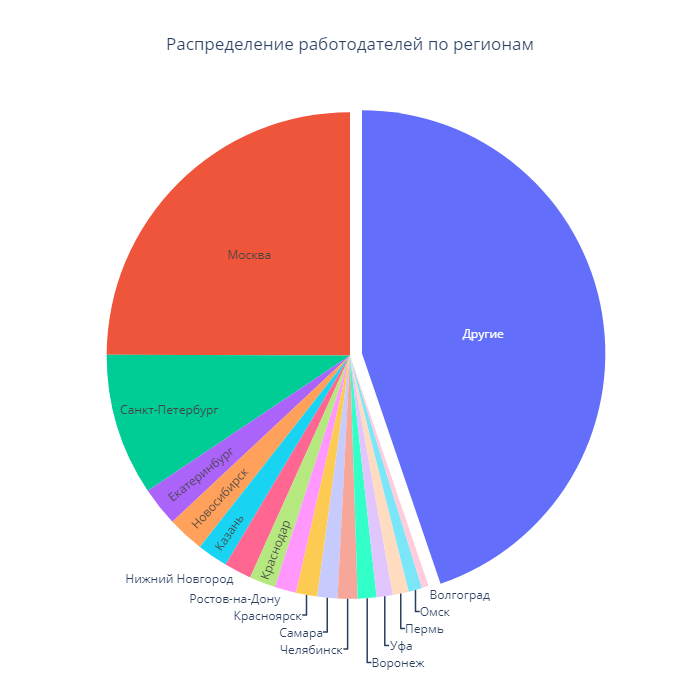

In [288]:
# Распределение работодателей по регионам
query_employers_area = f'''
                        -- Количество работодателей в городах-миллионниках
                        (SELECT
                             a.name AS "Регион",
                             COUNT(e.id) AS "Количество работодателей"
                         FROM employers AS e
                         JOIN areas AS a
                             ON e.area = a.id
                         WHERE a.name IN {tuple(million_cities)}
                         GROUP BY a.name
                         ORDER BY 2 DESC)
                        UNION ALL
                        -- Количество работодателей в остальных регионах
                        (SELECT
                             'Другие',
                             COUNT(e.id)
                         FROM employers AS e
                         JOIN areas AS a
                             ON e.area = a.id
                         WHERE a.name NOT IN {tuple(million_cities)})
                        '''
df_employers_area = pd.read_sql_query(query_employers_area, connection)

# Построение круговой диаграммы
figure_employers_area = go.Figure(data=go.Pie(labels=df_employers_area['Регион'],
                                              values=df_employers_area['Количество работодателей']))
# Стиль отображения
pull = list([0]*(df_employers_area.shape[0]-1))
pull.append(0.05)
figure_employers_area.update_traces(textinfo='label', # Содержимое подписи
                                    pull=pull, # Сдвиг сектора
                                    showlegend=False) # Скрыть легенду
# Размер полотна
figure_employers_area.update_layout(autosize = False, width = 700, height = 700)
# Заголовок диаграммы
figure_employers_area.update_layout(title='Распределение работодателей по регионам',
                                    title_x=0.5) # Расположение посередине
figure_employers_area.show("png")

Распределение работодателей по регионам показывает, что более половины работодателей зарегистрированы в городах-миллионниках, причем на Москву и Санкт-Петербург приходится около трети всех представленных в базе данных работодателей.

TOP-10 сфер деятельности: 
Разработка программного обеспечения
Системная интеграция,  автоматизации технологических и бизнес-процессов предприятия, ИТ-консалтинг
Интернет-компания (поисковики, платежные системы, соц.сети, информационно-познавательные и развлекательные ресурсы, продвижение сайтов и прочее)
Маркетинговые, рекламные, BTL, дизайнерские, Event-, PR-агентства, организация выставок
Консалтинговые услуги
Кадровые агентства
Электронно-вычислительная, оптическая, контрольно-измерительная техника, радиоэлектроника, автоматика (продвижение, оптовая торговля)
Розничная сеть (продуктовая)
Интернет-магазин
Архитектура, проектирование


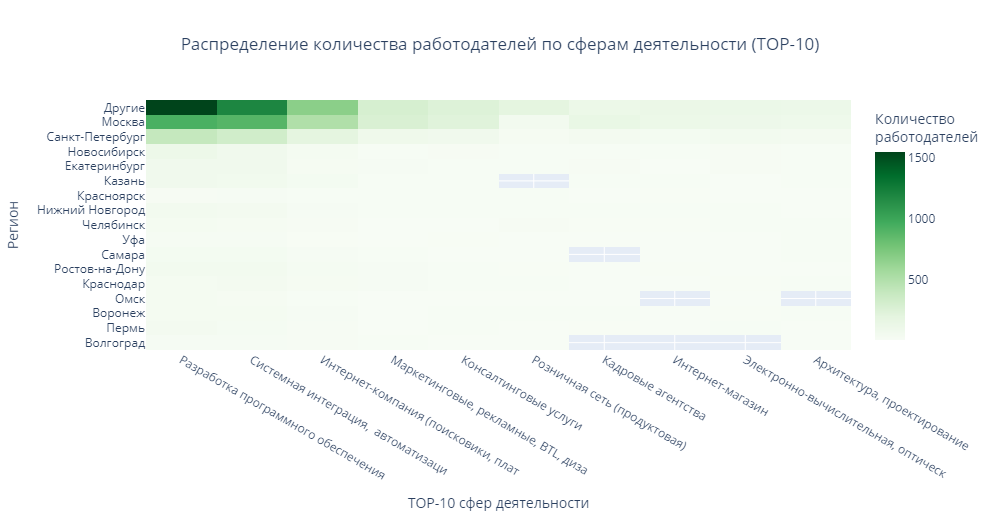

In [289]:
# Распределение работодателей по сферам деятельности
# Определение TOP-10 сфер деятельности
query_employers_industries = f'''
                              SELECT
                                  i.name AS "Сфера деятельности",
                                  COUNT(ei.employer_id) AS "Количество работодателей"
                              FROM employers_industries AS ei
                              JOIN industries AS i
                                  ON ei.industry_id = i.id
                              GROUP BY i.id
                              ORDER BY 2 DESC
                              LIMIT 10
                              '''
df_employers_industries = pd.read_sql_query(query_employers_industries, connection)
print('TOP-10 сфер деятельности: ', *df_employers_industries['Сфера деятельности'], sep='\n')

# Распределение наиболее популярных сфер деятельности по регионам
popular_industries = tuple(df_employers_industries['Сфера деятельности'])
query_employers_industries_area = f'''
                                   -- Количество компаний, работающих в ТОР-10 сфер деятельности
                                   -- в городах-миллионниках 
                                   (SELECT
                                        i.name AS "Сфера деятельности",
                                        a.name AS "Регион",
                                        COUNT(ei.employer_id) AS "Количество работодателей"
                                    FROM employers_industries AS ei
                                    LEFT JOIN industries AS i
                                        ON ei.industry_id = i.id
                                    LEFT JOIN employers AS e
                                        ON ei.employer_id = e.id
                                    LEFT JOIN areas AS a
                                        ON e.area = a.id
                                    WHERE i.name IN {popular_industries}
                                        AND a.name IN {tuple(million_cities)}
                                    GROUP BY i.id, a.id)
                                   UNION ALL
                                   -- Количество компаний, работающих в ТОР-10 сфер деятельности
                                   -- в других регионах
                                   (SELECT
                                        i.name,
                                        'Другие',
                                        COUNT(ei.employer_id)
                                    FROM employers_industries AS ei
                                    JOIN industries AS i
                                        ON ei.industry_id = i.id
                                    JOIN employers AS e
                                        ON ei.employer_id = e.id
                                    JOIN areas AS a
                                        ON e.area = a.id
                                    WHERE i.name IN {popular_industries}
                                        AND a.name NOT IN {tuple(million_cities)}
                                    GROUP BY i.id)
                                    ORDER BY 3 DESC
                                   '''
df_employers_industries_area = pd.read_sql_query(query_employers_industries_area, connection)

# Тепловая карта Тип рабочего графика - Тип трудоустройства
figure_employers_industries_area = go.Figure(data=go.Heatmap(x=df_employers_industries_area['Сфера деятельности'],
                                                             y=df_employers_industries_area['Регион'],
                                                             z=df_employers_industries_area['Количество работодателей'],
                                                             colorscale='Greens',
                                                             colorbar_title = 'Количество<br>работодателей'))
# Размер полотна
figure_employers_industries_area.update_layout(autosize = False, width = 1000, height = 520)
# Усечение длины подписей
figure_employers_industries_area.update_traces(x=[x[:35] for x in df_employers_industries_area['Сфера деятельности']])
# Порядок вывода категорий
cat = million_cities.copy()
cat = cat[::-1]
cat.append('Другие')
figure_employers_industries_area.update_yaxes(categoryorder='array', categoryarray=cat)
# Заголовк и подписи осей
figure_employers_industries_area.update_layout(title='Распределение количества работодателей по сферам деятельности (TOP-10)',
                                               title_x=0.5, # Выравнивание заголовка посередине
                                               yaxis_title='Регион', # Подпись Y
                                               xaxis_title='TOP-10 сфер деятельности') # Подпись Х
figure_employers_industries_area.show("png")

TOP-10 сфер деятельности по количеству работодателей, представленных в базе данных:
1. Разработка программного обеспечения
2. Системная интеграция,  автоматизации технологических и бизнес-процессов предприятия, ИТ-консалтинг
3. Интернет-компания (поисковики, платежные системы, соц.сети, информационно-познавательные и развлекательные ресурсы, продвижение сайтов и прочее)
4. Маркетинговые, рекламные, BTL, дизайнерские, Event-, PR-агентства, организация выставок
5. Консалтинговые услуги
6. Кадровые агентства
7. Электронно-вычислительная, оптическая, контрольно-измерительная техника, радиоэлектроника, автоматика (продвижение, оптовая торговля)
8. Розничная сеть (продуктовая)
9. Интернет-магазин
10. Архитектура, проектирование

Распределение количества работодателей по сферам деятельности показывает, что наибольшее количество работодателей задействовано в следующих сферах:
1. Разработка программного обеспечения
2. Системная интеграция,  автоматизации технологических и бизнес-процессов предприятия, ИТ-консалтинг
3. Интернет-компания (поисковики, платежные системы, соц.сети, информационно-познавательные и развлекательные ресурсы, продвижение сайтов и прочее)

Наибольшее количество работодателей зарегистрировано в Москве и Санкт-Петербурге, а также суммарно в других регионах. Следует отметить, что соотношение количества работодателей оценочно пропорционально населению региона.

In [290]:
# Распределение вакансий по работодателям
query_employers_top10 = f'''
                         -- ТОР-10 работодателей по количеству вакансий
                         SELECT e.name AS "Работодатель",
                         COUNT(v.id) AS "Количество вакансий"
                         FROM vacancies AS v
                         LEFT JOIN employers AS e
                             ON v.employer_id = e.id
                         GROUP BY e.name
                         ORDER BY COUNT(v.id) DESC
                         LIMIT 10
                         '''
df_employers_top10 = pd.read_sql_query(query_employers_top10, connection)
print('TOP-10 компаний по количеству вакансий:')
print(df_employers_top10)

TOP-10 компаний по количеству вакансий:
            Работодатель  Количество вакансий
0                 Яндекс                 1933
1             Ростелеком                  491
2               Тинькофф                  444
3                   СБЕР                  428
4          Газпром нефть                  331
5            ИК СИБИНТЕК                  327
6                    МТС                  292
7                DataArt                  247
8  Совкомбанк Технологии                  204
9             Первый Бит                  176


Среди TOP-10 компаний очевидным лидером по количеству вакансий является "Яндекс". Открытых вакансий у этой компании в 4 раза больше, чем у "Ростелекома", занимающего второе место, и почти в 11 раз больше, чем у "Первого Бита", находящегося на десятом месте.

In [291]:
# Количество вакансий, от работодателей, у которых не указана сфера деятельности
query_employers_no_industry = f'''
                               SELECT
                                   SUM(count) AS "Всего вакансий",
                                   AVG(count) AS "Среднее количество",
                                   MAX(count) AS "Максимальное количество"
                               FROM
                                   (SELECT
                                        COUNT(v.id)
                                    FROM vacancies AS v
                                    JOIN employers AS e
                                        ON v.employer_id = e.id
                                    LEFT JOIN employers_industries AS ei
                                        ON e.id = ei.employer_id
                                    WHERE ei.industry_id IS NULL -- Не указана сфера деятельности
                                    GROUP BY e.id) AS counts
                               '''
df_employers_no_industry = pd.read_sql_query(query_employers_no_industry, connection)
print('Вакансии работодателей, не указавших сферу деятельности:')
print(df_employers_no_industry)

# TOP-10 работодателей, не указавших сферу деятельности по количеству вакансий
query_employers_no_industry = f'''
                               SELECT
                                   e.name AS "Работодатель",
                                   COUNT(v.id) AS "Количество вакансий"
                                   FROM vacancies AS v
                                   JOIN employers AS e
                                       ON v.employer_id = e.id
                                   LEFT JOIN employers_industries AS ei
                                       ON e.id = ei.employer_id
                                   WHERE ei.industry_id IS NULL -- Не указана сфера деятельности
                                   GROUP BY e.id
                                   ORDER BY COUNT(v.id) DESC
                                   LIMIT 10
                               '''
df_employers_no_industry = pd.read_sql_query(query_employers_no_industry, connection)
print('TOP-10 работодателей, не указавших сферу деятельности по количеству вакансий:')
print(df_employers_no_industry)

Вакансии работодателей, не указавших сферу деятельности:
   Всего вакансий  Среднее количество  Максимальное количество
0         10084.0            2.033474                      151
TOP-10 работодателей, не указавших сферу деятельности по количеству вакансий:
                           Работодатель  Количество вакансий
0                            Спецремонт                  151
1                Поляков Денис Иванович                  127
2              Иннотех, Группа компаний                  122
3                     DNS Головной офис                   72
4                             ООО ЕФИН                    71
5                                 АЛНАС                   69
6                                Диплей                   68
7        РУСАЛ, Центр подбора персонала                   54
8                            Employcity                   47
9  Ростелеком Информационные Технологии                   46


В базе данных содержится информация о 8419 работодателях, не указавших сферу деятельности компании. На них приходится 10084 открытые вакансии. В среднем каждая подобная компания выставила две вакансии, максимальное количество вакансий - 151. Так как количество вакансий от подобных компаний составляет порядка 20%, а сфера деятельности компании является одним из важных параметров при поиске работы, предлагается для компаний, выставивших более 30-40 вакансий, найти/запросить дополнительную информацию о сфере их деятельности.

---

Таким образом, при анализе данных о работодателях выявлены явные лидеры по количеству выставленных вакансий. Подавляющаа часть работодателей сосредоточена в городах-миллионниках. Часть компаний размещают вакансии в нескольких регионах, что предполагает в большинстве случаев возможность удаленной работы, либо организацию переезда.  
Некоторые компании работают в нескольких сферах деятельности, также часть работодателей не указала этого параметра. С учетом важности данного признака и количества вакансий, размещенных такими компаниями, присутствует необходимость дополнительного поиска/запроса этой информации.

# Юнит 6. Предметный анализ

1. Сколько вакансий имеет отношение к данным?

Считаем, что вакансия имеет отношение к данным, если в её названии содержатся слова 'data' или 'данн'.

*Подсказка: Обратите внимание, что названия вакансий могут быть написаны в любом регистре.* 


In [292]:
# текст запроса
query_6_1 = f'''
             SELECT 
                 COUNT(v.id)
             FROM vacancies AS v
             WHERE v.name iLIKE '%data%'
                 OR v.name iLIKE '%данн%'
             '''

In [293]:
# результат запроса
df_6_1 = pd.read_sql_query(query_6_1, connection)
print(f"Количество вакансий, имеющих отношение к данным: {df_6_1['count'][0]}")

Количество вакансий, имеющих отношение к данным: 1771


2. Сколько есть подходящих вакансий для начинающего дата-сайентиста? 
Будем считать вакансиями для дата-сайентистов такие, в названии которых есть хотя бы одно из следующих сочетаний:
* 'data scientist'
* 'data science'
* 'исследователь данных'
* 'ML' (здесь не нужно брать вакансии по HTML)
* 'machine learning'
* 'машинн%обучен%'

** В следующих заданиях мы продолжим работать с вакансиями по этому условию.*

Считаем вакансиями для специалистов уровня Junior следующие:
* в названии есть слово 'junior' *или*
* требуемый опыт — Нет опыта *или*
* тип трудоустройства — Стажировка.
 

In [294]:
# текст запроса
query_6_2 = f'''
             SELECT 
                COUNT(v.id)
             FROM vacancies AS v
             WHERE
                 -- Условия вакансии DS
                 (v.name iLIKE '%data scientist%'
                  OR v.name iLIKE '%data science%'
                  OR v.name iLIKE '%исследователь данных%'
                  OR (v.name iLIKE '%ML%' 
                      AND v.name NOT iLIKE '%HTML%')
                  OR v.name iLIKE '%machine learning%'
                  OR v.name iLIKE '%машинн%обучен%')
                 AND
                 -- Условия для начинающего специалиста
                 (v.name iLIKE '%junior%'
                  OR v.experience = 'Нет опыта'
                  OR v.employment = 'Стажировка')
             '''

In [295]:
# результат запроса
df_6_2 = pd.read_sql_query(query_6_2, connection)
print(f"Количество вакансий, подходящих вакансий для начинающего дата-сайентиста: {df_6_2['count'][0]}")

Количество вакансий, подходящих вакансий для начинающего дата-сайентиста: 51


3. Сколько есть вакансий для DS, в которых в качестве ключевого навыка указан SQL или postgres?

** Критерии для отнесения вакансии к DS указаны в предыдущем задании.*

In [296]:
# текст запроса
query_6_3 = f'''
             SELECT 
                COUNT(v.id)
             FROM vacancies AS v
             WHERE
                 -- Условия вакансии DS
                 (v.name iLIKE '%data scientist%'
                  OR v.name iLIKE '%data science%'
                  OR v.name iLIKE '%исследователь данных%'
                  OR (v.name iLIKE '%ML%' 
                      AND v.name NOT iLIKE '%HTML%')
                  OR v.name iLIKE '%machine learning%'
                  OR v.name iLIKE '%машинн%обучен%')
                 AND
                 -- Условия ключевых навыков
                 (v.key_skills LIKE '%SQL%'
                  OR v.key_skills LIKE '%postgres%')
             '''

In [297]:
# результат запроса
df_6_3 = pd.read_sql_query(query_6_3, connection)
print(f"Количество вакансий, подходящих для начинающего дата-сайентиста с SQL или postgres: {df_6_3['count'][0]}")

Количество вакансий, подходящих для начинающего дата-сайентиста с SQL или postgres: 229


4. Проверьте, насколько популярен Python в требованиях работодателей к DS.Для этого вычислите количество вакансий, в которых в качестве ключевого навыка указан Python.

** Это можно сделать помощью запроса, аналогичного предыдущему.*

In [298]:
# текст запроса
query_6_4 = f'''
             SELECT 
                COUNT(v.id)
             FROM vacancies AS v
             WHERE
                 -- Условия вакансии DS
                 (v.name iLIKE '%data scientist%'
                  OR v.name iLIKE '%data science%'
                  OR v.name iLIKE '%исследователь данных%'
                  OR (v.name iLIKE '%ML%' 
                      AND v.name NOT iLIKE '%HTML%')
                  OR v.name iLIKE '%machine learning%'
                  OR v.name iLIKE '%машинн%обучен%')
                 -- Условия ключевых навыков
                 AND v.key_skills iLIKE '%python%'
             '''

In [299]:
# результат запроса
df_6_4 = pd.read_sql_query(query_6_4, connection)
print(f"Количество вакансий, подходящих для дата-сайентиста с Python: {df_6_4['count'][0]}")

Количество вакансий, подходящих для дата-сайентиста с Python: 357


5. Сколько ключевых навыков в среднем указывают в вакансиях для DS?
Ответ округлите до двух знаков после точки-разделителя.

In [300]:
# текст запроса
query_6_5 = f'''
             SELECT ROUND(AVG(ks.count_key_skills), 2)
             FROM
                 -- Подзапрос, определяющий количество ключевых навыков, указанных в вакансии DS
                 (SELECT 
                     v.key_skills,
                     -- Рассчет количества ключевых навыков в поле
                     (CHAR_LENGTH(v.key_skills) - CHAR_LENGTH(REPLACE(v.key_skills, '\t', ''))) / CHAR_LENGTH('\t') + 1 AS count_key_skills
                 FROM vacancies AS v
                 WHERE
                     -- Условия вакансии DS
                     v.name iLIKE '%data scientist%'
                     OR v.name iLIKE '%data science%'
                     OR v.name iLIKE '%исследователь данных%'
                     OR (v.name LIKE '%ML%' 
                         AND v.name NOT iLIKE '%HTML%')
                     OR v.name iLIKE '%machine learning%'
                     OR v.name iLIKE '%машинн%обучен%') AS ks
             '''

In [301]:
# результат запроса
df_6_5 = pd.read_sql_query(query_6_5, connection)
print(f"Среднее количество ключевых навыков в вакансиях, подходящих для дата-сайентиста: {df_6_5['round'][0]}")

Среднее количество ключевых навыков в вакансиях, подходящих для дата-сайентиста: 6.41


6. Напишите запрос, позволяющий вычислить, какую зарплату для DS в **среднем** указывают для каждого типа требуемого опыта (уникальное значение из поля *experience*). 

При решении задачи примите во внимание следующее:
1. Рассматриваем только вакансии, у которых заполнено хотя бы одно из двух полей с зарплатой.
2. Если заполнены оба поля с зарплатой, то считаем зарплату по каждой вакансии как сумму двух полей, делённую на 2. Если заполнено только одно из полей, то его и считаем зарплатой по вакансии.
3. Если в расчётах участвует null, в результате он тоже даст null (посмотрите, что возвращает запрос select 1 + null). Чтобы избежать этой ситуацию, мы воспользуемся функцией [coalesce](https://postgrespro.ru/docs/postgresql/9.5/functions-conditional#functions-coalesce-nvl-ifnull), которая заменит null на значение, которое мы передадим. Например, посмотрите, что возвращает запрос `select 1 + coalesce(null, 0)`

Выясните, на какую зарплату в среднем может рассчитывать дата-сайентист с опытом работы от 3 до 6 лет. Результат округлите до целого числа. 

In [302]:
# текст запроса
query_6_6 = f'''
             SELECT 
                 v.experience AS "Опыт работы",
                 ROUND(AVG((COALESCE(v.salary_from, v.salary_to) + COALESCE(v.salary_to, v.salary_from))/2)) AS "Средняя зарплата"
             FROM vacancies AS v
             WHERE
                 -- Условия вакансии DS
                 v.name iLIKE '%data scientist%'
                 OR v.name iLIKE '%data science%'
                 OR v.name iLIKE '%исследователь данных%'
                 OR (v.name LIKE '%ML%' 
                     AND v.name NOT iLIKE '%HTML%')
                 OR v.name iLIKE '%machine learning%'
                 OR v.name iLIKE '%машинн%обучен%'
             GROUP BY v.experience
             '''

In [303]:
# результат запроса
df_6_6 = pd.read_sql_query(query_6_6, connection)
print('Средняя предлагаемая зароботная плата в зависимости от опыта работы:')
print(df_6_6)

Средняя предлагаемая зароботная плата в зависимости от опыта работы:
          Опыт работы  Средняя зарплата
0         Более 6 лет               NaN
1           Нет опыта           74643.0
2  От 1 года до 3 лет          139675.0
3       От 3 до 6 лет          243115.0


***

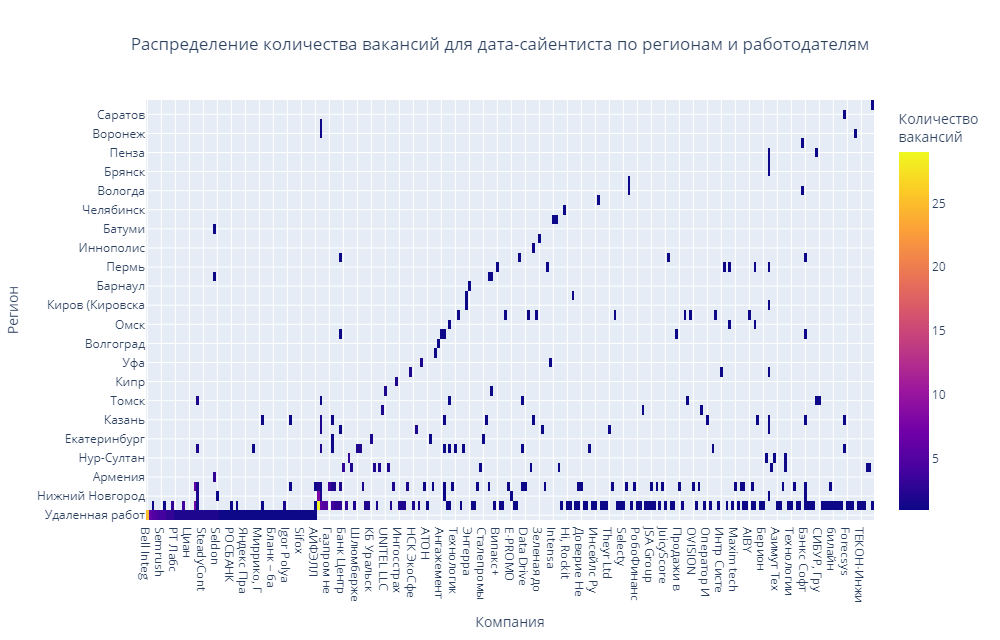

Общее количество вакансий для дата-сайентиста: 536
Количество работодателей, предлагающих вакансии для дата-сайентиста: 262
Количество вакансий дата-сайентиста на удаленную работу: 129
Количество вакансий дата-сайентиста в Москве: 180
Количество вакансий дата-сайентиста в Санкт-Петербурге: 58


In [304]:
# Запрос данных количества вакансий для дата-сайентиста по регионам и работодателям
query_vacancies_areas_employers = f'''
                                   -- Количество вакансий DS по работодателям на удаленную работу 
                                   (SELECT 
                                        e.name AS "Работодатель",
                                        'Удаленная работа' AS "Регион",
                                        COUNT(v.id) AS "Количество вакансий"
                                    FROM vacancies AS v
                                    JOIN employers AS e 
                                        ON v.employer_id = e.id
                                    WHERE
                                        -- Условия вакансии DS
                                        (v.name iLIKE '%data scientist%'
                                         OR v.name iLIKE '%data science%'
                                         OR v.name iLIKE '%исследователь данных%'
                                         OR (v.name iLIKE '%ML%' 
                                             AND v.name NOT iLIKE '%HTML%')
                                         OR v.name iLIKE '%machine learning%'
                                         OR v.name iLIKE '%машинн%обучен%')
                                        -- Удаленная работа 
                                        AND v.schedule = 'Удаленная работа' 
                                    GROUP BY e.id
                                    ORDER BY "Количество вакансий" DESC)
                                   UNION ALL
                                   -- Количество вакансий DS по работодателям и регионам,
                                   -- исключая удаленную работу
                                   (SELECT 
                                        e.name AS "Работодатель",
                                        a.name AS "Регион",
                                        COUNT(v.id) AS "Количество вакансий"
                                    FROM vacancies AS v
                                    JOIN employers AS e 
                                        ON v.employer_id = e.id
                                    JOIN areas AS a 
                                        ON v.area_id = a.id
                                    WHERE
                                        -- Условия вакансии DS
                                        (v.name iLIKE '%data scientist%'
                                         OR v.name iLIKE '%data science%'
                                         OR v.name iLIKE '%исследователь данных%'
                                         OR (v.name iLIKE '%ML%' 
                                             AND v.name NOT iLIKE '%HTML%')
                                         OR v.name iLIKE '%machine learning%'
                                         OR v.name iLIKE '%машинн%обучен%')
                                        -- Без удаленной работы 
                                        AND v.schedule <> 'Удаленная работа'
                                    GROUP BY e.id, a.id
                                    ORDER BY "Количество вакансий" DESC)
                                   '''                                   
df_vacancies_areas_employers = pd.read_sql_query(query_vacancies_areas_employers, connection)

# Тепловая карта Распределение количества вакансий для дата-сайентиста по регионам и работодателям
figure_vacancies_areas_employers = go.Figure(data=go.Heatmap(x=df_vacancies_areas_employers['Работодатель'],
                                                             y=df_vacancies_areas_employers['Регион'],
                                                             z=df_vacancies_areas_employers['Количество вакансий'],
                                                             colorbar_title = 'Количество<br>вакансий'))
# Размер полотна
figure_vacancies_areas_employers.update_layout(autosize = False, width = 1000, height = 640)
# Усечение длины подписей
figure_vacancies_areas_employers.update_traces(x=[x[:10] for x in df_vacancies_areas_employers['Работодатель']],
                                               y=[y[:15] for y in df_vacancies_areas_employers['Регион']])
# Заголовк и подписи осей
figure_vacancies_areas_employers.update_layout(title='Распределение количества вакансий для дата-сайентиста по регионам и работодателям',
                                               title_x=0.5, # Выравнивание заголовка посередине
                                               yaxis_title='Регион', # Подпись Y
                                               xaxis_title='Компания') # Подпись Х
figure_vacancies_areas_employers.show("png")

# Вывод информации для итогов
print(f"Общее количество вакансий для дата-сайентиста: {df_vacancies_areas_employers['Количество вакансий'].sum()}")
print(f"Количество работодателей, предлагающих вакансии для дата-сайентиста: {df_vacancies_areas_employers['Работодатель'].nunique()}")
count_remote = df_vacancies_areas_employers[df_vacancies_areas_employers['Регион'] == 'Удаленная работа']['Количество вакансий'].sum()
print(f"Количество вакансий дата-сайентиста на удаленную работу: {count_remote}")
count_MSK = df_vacancies_areas_employers[df_vacancies_areas_employers['Регион'] == 'Москва']['Количество вакансий'].sum()
print(f"Количество вакансий дата-сайентиста в Москве: {count_MSK}")
count_SpB = df_vacancies_areas_employers[df_vacancies_areas_employers['Регион'] == 'Санкт-Петербург']['Количество вакансий'].sum()
print(f"Количество вакансий дата-сайентиста в Санкт-Петербурге: {count_SpB}")

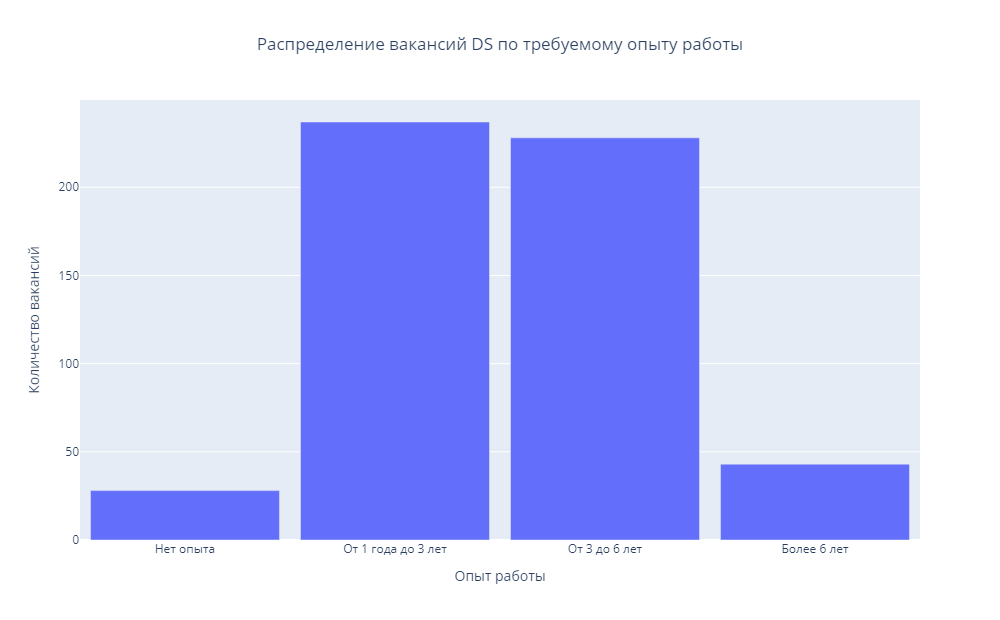

In [305]:
# Распределение вакансий DS по требуемому опыту работы
query_ds_experience = f'''
                       SELECT 
                           v.experience AS "Опыт работы",
                           COUNT(v.id) AS "Количество вакансий"
                       FROM vacancies AS v
                       WHERE
                           -- Условия вакансии DS
                           v.name iLIKE '%data scientist%'
                           OR v.name iLIKE '%data science%'
                           OR v.name iLIKE '%исследователь данных%'
                           OR (v.name iLIKE '%ML%' 
                               AND v.name NOT iLIKE '%HTML%')
                           OR v.name iLIKE '%machine learning%'
                           OR v.name iLIKE '%машинн%обучен%'
                       GROUP BY v.experience
                       ORDER BY COUNT(v.id)
                       '''
df_ds_experience = pd.read_sql_query(query_ds_experience, connection)
# Закрытие подключения
connection.close()

# Распределение категорий признака Требования к опыту
figure_experience = go.Figure(data=go.Bar(x=df_ds_experience['Опыт работы'],
                                          y=df_ds_experience['Количество вакансий']))
figure_experience.update_layout(autosize = False, width = 1000, height = 620, # Размер полотна
                                bargap=0.1) # Расстояние между столбцами
# Порядок вывода категорий
figure_experience.update_xaxes(categoryorder='array',
                               categoryarray=["Нет опыта", "От 1 года до 3 лет", "От 3 до 6 лет", "Более 6 лет"]) 
# Заголовк и подписи осей
figure_experience.update_layout(title='Распределение вакансий DS по требуемому опыту работы',
                                title_x=0.5, # Выравнивание заголовка посередине
                                xaxis_title='Опыт работы', # Подпись Х
                                yaxis_title='Количество вакансий') # Подпись Y
figure_experience.show("png")

Наибольшее количество вакансий открыто в Москве и Санкт-Петербурге, а также с вариантом удаленной работы (суммарно составляют 68% от общего числа вакансий DS). Поэтому для соискателей из регионов наиболее вероятен вариант трудоустройства с возможностью удаленной работы, либо с вариантом переезда.  
Доля упоминаний среди ключевых навыков Python и SQL (postgres) достаточно высока, чтобы утверждать об их важности для каждого претендующего на должность дата-сайентиста, но далеко не единственные, так как в среднем указывают 6-7 ключевых навыков.  
Крайне низкая потребность в дата-сайентистах без опыта, компании предпочитают работать  сразу с опытными специалистами.  
Низкая степень заполненности данных по заработной плате объясняется распространением среди работодателей практики определения ее величины по результатам собеседования, а также подписания соглашения о неразглашении данной информации при приеме на работу. В среднем претендентам без опыта работы приходится расчитывать на заработную плату в размере около 75 т.р., но по истечению первого года работы возможно ее увеличение почти в два раза. Такой существенный разрыв в величине относительно опыта работы можно объяснить отсутствием достаточного количества свободных опытных специалистов в данном направлении. Со временем этот разрыв будет уменьшаться по мере насыщения рынка опытными специалистами.

# Общий вывод по проекту

Для дата-сайнтиста в текущем слепке базы данных вакансий присутствует 536 предложений от 262 работодателей. 129 из них- предложения без привязки к региону (удаленный режим работы).  
Исходя из текущих данных проще всего будет устроиться специалисту, проживающему в Москве или ориентированному на удаленную работу, с опытом работы от одного года до шести лет, обладающего навыками по Python, SQL и еще порядка 4-5, с запросом на заработную плату ориентировочно в 140 - 240 тыс.руб. (в зависимости от величины опыта работы) ввиду преобладающего количества предложений с данными параметрами.  

Более полный анализ возможен при получении данных об уже закрытых вакансиях представленных компаний, размещенных ими ранее на платформе. Эти данные позволят дать оценку качества работодателей, определить текучесть кадров по отдельным должностям и выстроить рейтинг рекомендаций с учетом данного признака. Дополнительным показателем является причина возникновения вакансии, например, расширение штата, повышение сотрудника, ранее занимавшего данную должность, увольнение сотрудника по собственному желанию и т.п.  
Для оценки масштаба компании важной информацией является размер штата и ориентировочный объем исполняемых обязанностей (например, предполагается работать одному или в команде, над одной конкретной задачей или параллельно вести несколько проектов).  
Интересным дополнением были бы следующие исторические данные: открытие вакансии и ее закрытие, какие компании быстрее находят специалистов, среднее количество откликов перед закрытием вакансии компании. В рамках последнего признака необходимо иметь данные по количеству откликов на текущие открытые вакансии.  
Также в базе данных отсутствует информация об условиях работы (социальные гарантии, корпоративная культура, способ оформления трудовых отношений и т.п.).

Таким образом, информация, представленная в базе данных, в целом соответствует целям проекта и может быть использована в качестве отправной точки для создания модели машинного обучения, которая будет рекомендовать вакансии клиентам агентства, претендующим на позицию Data Scientist.